In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
from models.detector import Detector
from models.place_classifier import PlaceClassifier
from models.features_extractor import FeatureExtractor

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
from utils.dataset_parser import DatasetParser

In [5]:
from transformers import DistilBertModel, DistilBertConfig
from transformers import DistilBertTokenizer, DistilBertModel

In [7]:
classifier = PlaceClassifier()

In [8]:
detector = Detector()

INFO:absl:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
configuration = DistilBertConfig()

In [10]:
model_nlp = DistilBertModel(configuration)

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [6]:
data_parser = DatasetParser('dataset')

In [7]:
def get_embedding(inputs):
    inputs = tokenizer(inputs, return_tensors="pt")
    outputs = model_nlp(**inputs)
    embeddings = outputs.last_hidden_state[:, -1].mean(axis = 0).detach().numpy()
    return embeddings

In [8]:
def get_objects_embedding(objects):
    obj_embeddings = []
    for obj in objects:
         obj_embeddings.append(get_embedding(obj))
    if len(obj_embeddings) == 0:
        return []
    else:
        mean_obj_emb = np.mean(obj_embeddings, axis = 0)
    return mean_obj_emb

In [9]:
def get_places_embedding(places_dict):
    places = places_dict.keys()
    places_emb = []
    for place in places:
        place = place.split('/')[0].replace('_', ' ')
        place_emb = get_embedding(place)
        places_emb.append(place_emb)
    if len(place_emb) == 0:
        return []
    mean_places_emb = np.mean(places_emb, axis = 0)
    return mean_places_emb

In [10]:
def get_pic_embeddings(img_path, model):
    image = tf.image.decode_png(tf.io.read_file(img_path))
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis = 0)
    result = model(image)
    return result

In [11]:
image_features_extractor = FeatureExtractor()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
normalization_1 (Normalizati (None, 1536)              3073      
Total params: 10,786,608
Trainable params: 0
Non-trainable params: 10,786,608
_________________________________________________________________


In [ ]:
# imgs_embeddings = []
imgs_tags = []
imgs_pic_embeddings = []
imgs_paths = []

for img_path, tags in tqdm(zip(data_parser.imgs_paths, data_parser.tags)):
    img = Image.open(img_path)
    imgs_paths.append(img_path)
    imgs_tags.append(tags)
#     places_dict, _ = classifier.predict(np.array(img))
#     objects = detector.get_objects_on_img(img, min_score = 0.2)
    pic_embeddings = image_features_extractor.get_features(img)
    imgs_pic_embeddings.append(pic_embeddings)
#     if (len(objects) == 0) or len(places_dict) == 0:
#         continue
#     obj_emb = get_objects_embedding(objects)
#     places_emb = get_places_embedding(places_dict)
#     embedding = np.mean([obj_emb, places_emb], axis = 0)
#     embedding = obj_emb
#     imgs_embeddings.append(embedding)
    img.close()

12201it [52:39,  3.86it/s]

In [29]:
imgs_embeddings_array = np.array(imgs_embeddings)

In [30]:
pic_embeddings_array = np.array(imgs_pic_embeddings).reshape(-1, 1536)

In [31]:
pic_embeddings_array.shape

(9620, 1536)

In [32]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, AffinityPropagation

In [101]:
# knn_words = NearestNeighbors()
knn_pic = NearestNeighbors(n_neighbors=5)

In [102]:
# knn_words.fit(imgs_embeddings_array)
knn_pic.fit(pic_embeddings_array)

NearestNeighbors()

In [103]:
def print_idx_tags(id_list, tags, images, plot_images : bool = True):
    for id_ in id_list:
        print(f"Tags: {tags[id_]}")
        if plot_images:
            plt.imshow(images[id_])
            plt.show()

In [104]:
def filter_by_distance(imgs_ids, distances, tresh_distance = 15.0):
    result_ids = []
    for id_, distance in zip(imgs_ids, distances):
        if distance <= tresh_distance:
            result_ids.append(id_)
    return result_ids

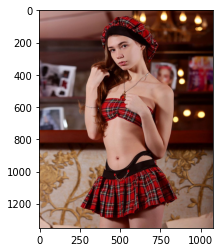

Real tags: ['#model', '#photo', '#newmodel', '#swimsuit', '#photosession', '#live', '#love', '#instagramm', '#russiangirl', '#beauty', '#beautiful', '#world']
Tags: ['#model', '#photo', '#newmodel', '#swimsuit', '#photosession', '#live', '#love', '#instagramm', '#russiangirl', '#beauty', '#beautiful', '#world']


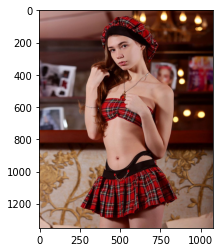

Tags: ['#model', '#photography', '#love', '#live', '#brunette', '#longhair', '#greeneyes', '#russiangirl', '#beautiful', '#valerisowa', '#модель', '#фотосессия', '#любовь', '#жизньпрекрасна', '#брюнетка', '#длинныеволосы', '#зеленыеглаза', '#русскаядевушка', '#красота', '#валерисова']


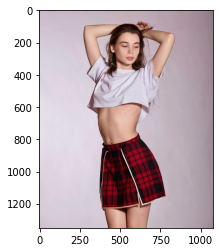

Tags: ['#model', '#photography', '#love', '#live', '#red', '#brunette', '#longhair', '#greeneyes', '#russiangirl', '#beautiful', '#valerisowa', '#модель', '#фотосессия', '#любовь', '#жизньпрекрасна', '#брюнетка', '#длинныеволосы', '#зеленыеглаза', '#русскаядевушка', '#красота', '#валерисова']


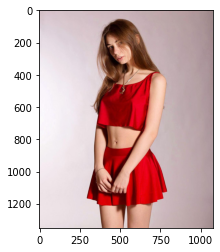

Tags: ['#model', '#photography', '#love', '#live', '#brunette', '#longhair', '#greeneyes', '#russiangirl', '#beautiful', '#valerisowa', '#модель', '#фотосессия', '#любовь', '#жизньпрекрасна', '#брюнетка', '#длинныеволосы', '#зеленыеглаза', '#русскаядевушка', '#красота', '#валерисова']


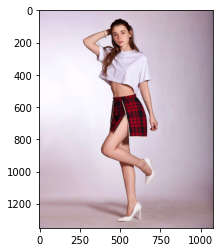

Tags: ['#model', '#photo', '#girl', '#model', '#newmodel', '#swimsuit', '#summer', '#way', '#travel', '#poliway', '#photosession', '#live', '#love', '#instagramm', '#russiangirl', '#beauty', '#beautiful', '#world', '#фото', '#модель', '#бьюти', '#фешен', '#девушка']


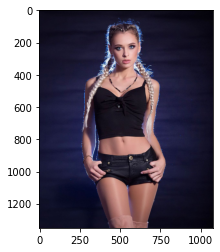

In [138]:
idx = 3013
plt.imshow(imgs[idx])
plt.show()

# example_word = imgs_embeddings[idx : idx + 1]
example_pic = imgs_pic_embeddings[idx].reshape(1, -1)

# results_word = knn_words.kneighbors(example_word, return_distance = False)
distanses, results_pic = knn_pic.kneighbors(example_pic, return_distance = True)
distanses = distanses[0]
results_pic = results_pic[0]
results_pic = filter_by_distance(results_pic, distanses)
real_tags = imgs_tags[idx]
print(f"Real tags: {real_tags}")
print_idx_tags(results_pic, imgs_tags, imgs)

In [ ]:
# for res_img, res_word in zip(results_pic, results_word):
#     for pred_idx_img, pred_idx_word in zip(res_img, res_word):
#         print("======================================================================")
# #         print('Words')
# #         plt.imshow(imgs[pred_idx_word])
# #         plt.show()
# #         print(f"Pred tags: {imgs_tags[pred_idx_word]}")
#         print("Images")
#         plt.imshow(imgs[pred_idx_img])
#         plt.show()
#         print(f"Pred tags: {imgs_tags[pred_idx_img]}")
#         print("=======================================================================")
#     print()

In [149]:
def get_hashtags(tags_list, n_similar_tags = 2):
    counters = Counter(tags_list)
    result = []
    for tag, counter in counters.items():
        if counter >= n_similar_tags:
            result.append(tag)
    return result

In [150]:
predicted_tags = [el for i in results_pic for el in imgs_tags[i]]
get_hashtags(predicted_tags)

['#model',
 '#photo',
 '#newmodel',
 '#swimsuit',
 '#photosession',
 '#live',
 '#love',
 '#instagramm',
 '#russiangirl',
 '#beauty',
 '#beautiful',
 '#world',
 '#photography',
 '#brunette',
 '#longhair',
 '#greeneyes',
 '#valerisowa',
 '#модель',
 '#фотосессия',
 '#любовь',
 '#жизньпрекрасна',
 '#брюнетка',
 '#длинныеволосы',
 '#зеленыеглаза',
 '#русскаядевушка',
 '#красота',
 '#валерисова']